In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime

In [2]:
from financepy.utils import *
from financepy.products.equity import *
from financepy.market.curves import *
from financepy.products.rates import *

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:42 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



### Q8. Bloomberg derivatives valuation

The product is a down-and-in knock option on the stock of Adidas. 
In order to get aligned with the FinancePy library, we chose the Black-Schole continuous model.
To avoid introducing a discounting bias in the pricing, we chose to set the dividends equal to 0%.
The implied volatility is 41.035% and the interest rate on the market is **1.943%**.<br>

The market price of this option is **9.74€**.

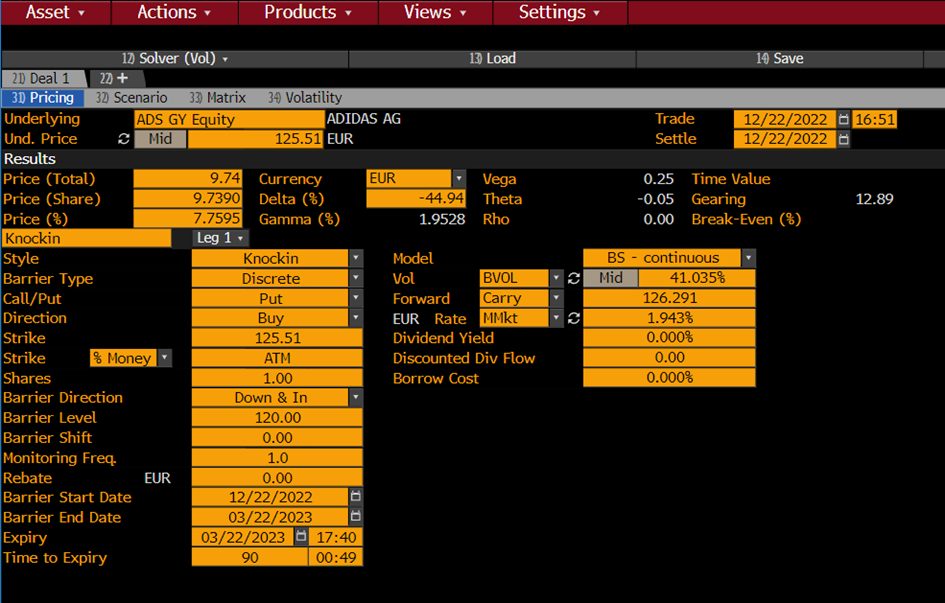

The option is chosen at the money, and the maturity is 3 months (90 days), so the expiry is 22nd March 2023.
The barrier level is 120€, it means that before reaching this price, the option is not activated and the investor doesn't make any profit. 
With a long position on this option, the investor has a very bearish view. He is ready to sacrify part of the payoff if the spot ends between the strike and the barrier. The reward for this is that the option is cheaper than the vanilla one.

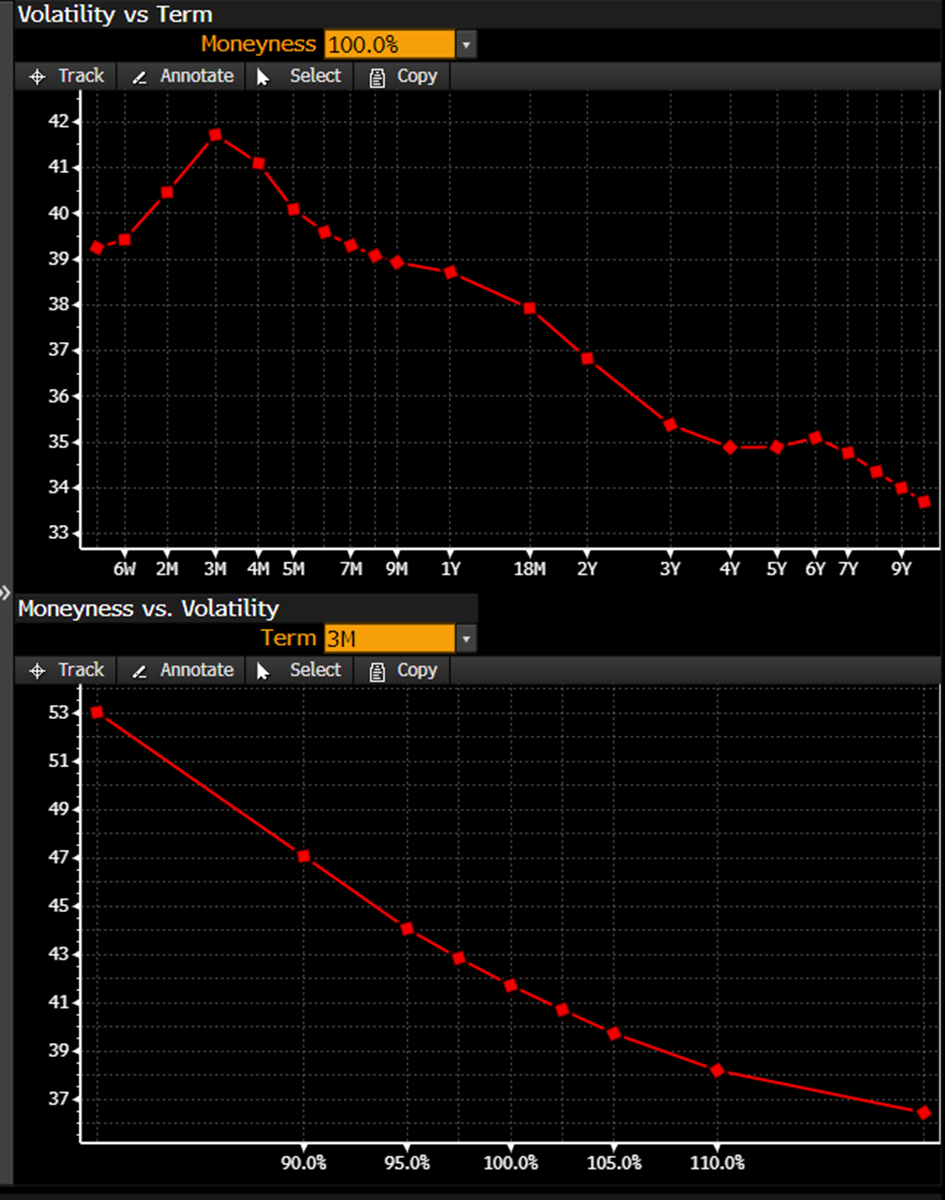

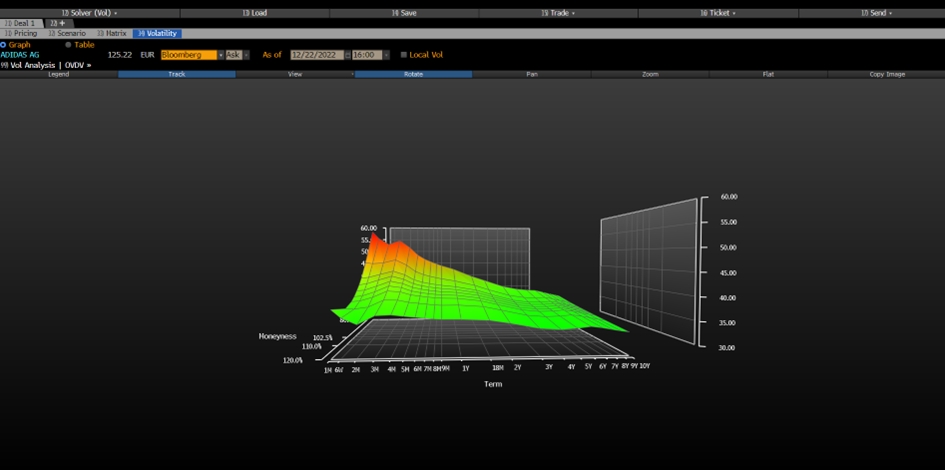

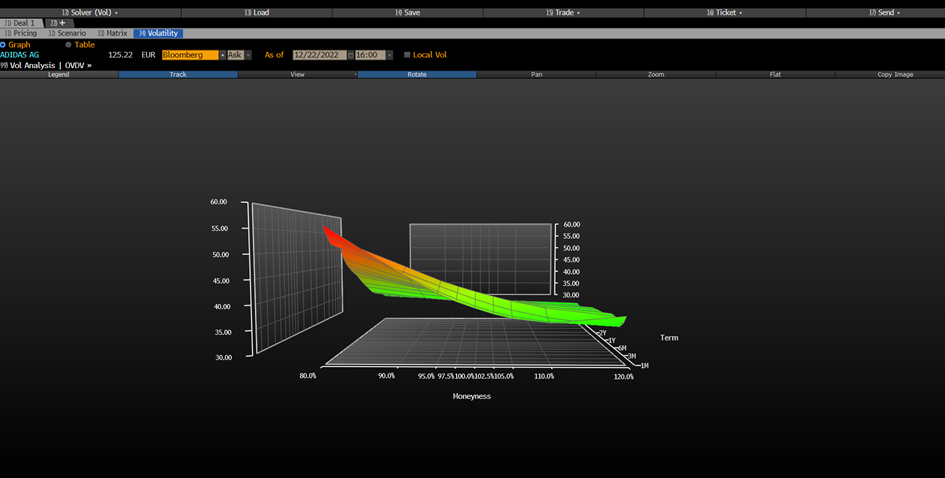

This graphs show the volatility skew. This is aligned with the equity volatility shape. As it is not constant at 41.035%, this can be a source of difference between the Bloomberg pricing and the FinancePy pricing.
Moreover the 2 dimension graph below is a snapshot of the 3 dimension graph on the expiry date in 3 months.

#### Q.c 
We use the greeks as risk-measures to draw our exposure to changes in the underlying, volatility or time.
<br> Delta is given by:
$$ {\delta} = \frac{\partial P(t)}{\partial S}$$
<br> Gamma is given by:
$$ {\gamma} =\frac{\partial^2P(t)}{\partial S^2}$$
<br> Vega is given by:
$$ vega = \frac{\partial P(t)}{\partial {\sigma}}$$
<br> Theta is given by:
$$ {\theta} = \frac{\partial P(t)}{\partial t}$$

As shown in the question 8.a., the values of the greeks are the following ones:
Delta is -44.94%, so an increase in 1€ on the Adidas stock value reduces the option price by 0.4494€.
This negative figure makes sense because we are long a put. <br>
The gamma is 1.9528%, so an increase in delta implies a small increase in gamma.
As expected, vega is positive as we are long, if the volatility increases by 1%, the option value increases by 0.25€.
Eventually, theta is negative, which is logical because the longer the maturity, the higher the likelihood to first hit the barrier and then end up in the money.<br>
As we will see in the question 8.d., theta corresponds to the daily value loss of the option due to the time passing.<br>
On the valuation part, the curve below shows how the P&L evolves with repect to the underlying price.
As expected, it is a decreasing function of the underlying. The investor expects a bigger profit for a lower underlying price.

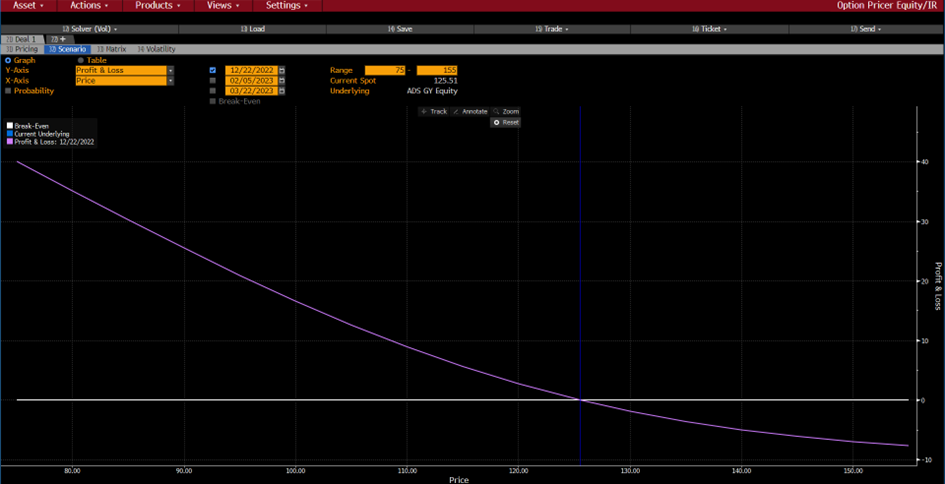

#### Q.8.d
Now we will try to reproduce these Greeks in two ways:
- directly with FinancePy functions
- thanks to some results from FinancePy and some calculations based on the Greeks formulas detailed in question 8.c.

In [3]:
interest_rate = 0.01943
valuation_date = Date(22, 12, 2022)
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)
dividend_yield = 0.0
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
volatility = 0.41035
model = BlackScholes(volatility)
expiry_date = Date(22, 3, 2023)

In [4]:
barrierType = EquityBarrierTypes.DOWN_AND_IN_PUT

In [5]:
strike_price = 125.51
barrier_price = 120
stock_price=125.51

In [6]:
barrierOpt = EquityBarrierOption(expiry_date, strike_price, barrierType, barrier_price)

We create the dataframe "summary" to summarize the different Grreks value based on our three sources:

- Bloomberg, these value are the genuine market ones
- The ones directly got from FinancePy
- The ones we computed to the orevious formulas

In [7]:
summary=pd.DataFrame(columns=["Bloomberg","FinancePy","FP_vs_BBG","Calculation","Calculation_vs_BBG"],index=["value","delta","gamma","vega","theta"])
summary.Bloomberg=[9.74,-0.4494,0.019528,0.25,-0.05]

In [8]:
value_FP = barrierOpt.value(valuation_date, stock_price, discount_curve, dividend_curve, model)
delta_FP = barrierOpt.delta(valuation_date, stock_price, discount_curve, dividend_curve, model)
gamma_FP=barrierOpt.gamma(valuation_date, stock_price, discount_curve, dividend_curve, model)
vega_FP=barrierOpt.vega(valuation_date, stock_price, discount_curve, dividend_curve, model)
theta_FP=barrierOpt.theta(valuation_date, stock_price, discount_curve, dividend_curve, model)
list_FP=[value_FP,delta_FP,gamma_FP,vega_FP,theta_FP]
summary.FinancePy=list_FP
print(summary)

       Bloomberg  FinancePy FP_vs_BBG Calculation Calculation_vs_BBG
value   9.740000   9.840027       NaN         NaN                NaN
delta  -0.449400  -0.453059       NaN         NaN                NaN
gamma   0.019528   0.015604       NaN         NaN                NaN
vega    0.250000   0.247725       NaN         NaN                NaN
theta  -0.050000 -19.436566       NaN         NaN                NaN


Very interestingly, the delta is above the theoretical value -0.5. The first reason is that in Black-Scholes formula, when K=S the delta is slightly above -0.5. Moreover, the delta curve of a barrier option is not always the same as a the one of the one of a vanilla option.

To compute delta, we shock the spot by 1 euro:

<br>
$$ {\delta} = \frac{\partial P(t)}{\partial S}$$

In [9]:
value_before=value_FP
value_after=barrierOpt.value(valuation_date, stock_price+1, discount_curve, dividend_curve, model)
delta=(value_after-value_before)
delta

-0.44529903075680544

To compute gamma, we shock the spot once again but now we look at the change in delta.

<br> We use this formula for gamma:
$$ {\gamma} = \frac{\partial {\delta}(t)}{\partial S}$$

In [10]:
delta_before=delta_FP
delta_after=barrierOpt.delta(valuation_date, stock_price+1, discount_curve, dividend_curve, model)
gamma=(delta_after-delta_before)/2
gamma.round(8)

0.00774392

To compute vega, we shock the volatility  by 1% and we look at the new option value:
    
<br>
$$ vega = \frac{\partial P(t)}{\partial {\sigma}}$$

In [11]:
value_after_vol=barrierOpt.value(valuation_date, stock_price, discount_curve, dividend_curve, BlackScholes(volatility+0.01))
vega=(value_after_vol-value_before)
vega.round(8)

0.24772487

To compute theta, we calculate with FinancePy the change in option value by settiing all the parameters equal, except the date, we take the day after.

<br>
$$ {\theta} = \frac{\partial P(t)}{\partial t}$$

In [12]:
discount_curve_later = DiscountCurveFlat(Date(23,12,2022), interest_rate)
dividend_curve_later = DiscountCurveFlat(Date(23,12,2022), dividend_yield)
value_later = barrierOpt.value(Date(23,12,2022), stock_price, discount_curve_later, dividend_curve_later, model)
theta=value_later-value_before
theta.round(8)

-0.05325086

In [13]:
#we also take the FinancePy value in the Calculation column
summary.Calculation=[value_FP,delta,gamma,vega,theta]

In [14]:
summary.FP_vs_BBG=(summary.FinancePy-summary.Bloomberg)/summary.Bloomberg
summary.Calculation_vs_BBG=(summary.Calculation-summary.Bloomberg)/summary.Bloomberg

In [15]:
summary.style.format({'FP_vs_BBG': "{:.2%}",'Calculation_vs_BBG': "{:.2%}"})

,Bloomberg,FinancePy,FP_vs_BBG,Calculation,Calculation_vs_BBG
value,9.740000,9.840027,1.03%,9.840027,1.03%
delta,-0.449400,-0.453059,0.81%,-0.445299,-0.91%
gamma,0.019528,0.015604,-20.09%,0.007744,-60.34%
vega,0.250000,0.247725,-0.91%,0.247725,-0.91%
theta,-0.050000,-19.436566,38773.13%,-0.053251,6.50%


**Summary:**<br>
    
FinancePy provides a very good approximation of the market price with only 1% difference.
Regarding delta, it is a slightly better approximation than the simulated 1€ shock. On the same direction, the difference is -20% for the FinancePy gamma, whereas the delta shock method does really bad.<br>
As displayed in the previous question, the volatility skew implies a weakness for a model assuming a flat volatility curve, hence the difference between FinancePy and Bloomberg.<br>
We can reckon vega is a quite good approximation since the difference is less than 1% with the actual vega.
The issue is the theta approximation. The obtained theta is much too high and very unrealistic. On the contrary, the shock method does quite well with only 6.5% error.<br> <br>

**Conclusion:** FinancePy gives a pretty good picture for the option price and Greeks replication, except for theta. The shock method gives a better approximation and the option analysis can be done by combining these two methods.